.. index:: Equations; Cahn-Hilliard

# Cahn-Hilliard
In this script we show how to use the $C^1$ non-conforming virtual
element space to solve the Cahn-Hilliard equation. We use a fully implicit
scheme here. You can find more details in <cite data-cite="VEM"></cite>

In [1]:
try:
    import dune.vem
except:
    print("This example needs 'dune.vem' - skipping")
    import sys
    sys.exit(0)
from matplotlib import pyplot
import random
from dune.grid import cartesianDomain, gridFunction
import dune.fem
from dune.fem.plotting import plotPointData as plot
from dune.fem.function import discreteFunction

from ufl import *
import dune.ufl

dune.fem.threading.use = 4

Grid and space construction - we use a cube grid here:

In [2]:
order        = 3
polyGrid = dune.vem.polyGrid( cartesianDomain([0,0],[1,1],[30,30]), cubes=True)
ncC1testSpaces = [ [0], [order-3,order-2], [order-4] ]
space = dune.vem.vemSpace(polyGrid, order=order, testSpaces=ncC1testSpaces)

To define the mathematical model, let $\psi\colon{\mathbb R} \rightarrow
\mathbb{R}$ be defined as
$\psi(x) = \frac{(1-x^2)^2}{4}$ and let $\phi(x) = \psi(x)^{\prime}$.
The strong form for the solution
$u\colon \Omega \times [0,T] \rightarrow {\mathbb R}$
is given by
\begin{align*}
\partial_t u  - \Delta (\phi(u)-\epsilon^2 \Delta u) = 0
\quad &\text{in} \ \Omega \times [0,T] ,\\
u(\cdot,0) = u_0(\cdot)  \quad &\text{in} \ \Omega,\\
\partial_n u = \partial_n \big( \phi(u) - \epsilon^2\Delta u \big) = 0
\quad &\text{on} \ \partial \Omega \times [0,T].
\end{align*}

We use a backward Euler discretization in time and will fix the constant
further down:

In [3]:
t     = dune.ufl.Constant(0,"time")
tau   = dune.ufl.Constant(0,"dt")
eps   = dune.ufl.Constant(0,"eps")
df_n  = discreteFunction(space, name="oldSolution") # previous solution
x     = SpatialCoordinate(space)
u     = TrialFunction(space)
v     = TestFunction(space)

H     = lambda v: grad(grad(v))
laplace = lambda v: H(v)[0,0]+H(v)[1,1]
a     = lambda u,v: inner(H(u),H(v))
b     = lambda u,v: inner( grad(u),grad(v) )
W     = lambda v: 1/4*(v**2-1)**2
dW    = lambda v: (v**2-1)*v

equation = ( u*v + tau*eps*eps*a(u,v) + tau*b(dW(u),v) ) * dx == df_n*v * dx

dbc = [dune.ufl.DirichletBC(space, 0, i+1) for i in range(4)]

# energy
Eint  = lambda v: eps*eps/2*inner(grad(v),grad(v))+W(v)

Next we construct the scheme providing some suitable expressions to stabilize the method

In [4]:
biLaplaceCoeff = eps*eps*tau
diffCoeff      = 2*tau
massCoeff      = 1
scheme = dune.vem.vemScheme(
                       [equation, *dbc],
                       solver=("suitesparse","umfpack"),
                       hessStabilization=biLaplaceCoeff,
                       gradStabilization=diffCoeff,
                       massStabilization=massCoeff,
                       boundary="derivative") # only fix the normal derivative = 0

To avoid problems with over- and undershoots we project the initial
conditions into a linear lagrange space before interpolating into the VEM
space:

In [5]:
def initial(x):
    h = 0.01
    g0 = lambda x,x0,T: conditional(x-x0<-T/2,0,conditional(x-x0>T/2,0,sin(2*pi/T*(x-x0))**3))
    G  = lambda x,y,x0,y0,T: g0(x,x0,T)*g0(y,y0,T)
    return 0.5*G(x[0],x[1],0.5,0.5,50*h)
initial = dune.fem.space.lagrange(polyGrid,order=1).interpolate(initial(x),name="initial")
df = space.interpolate(initial, name="solution")

Finally the time loop:

[ 1 ] 0.09999999999999999 0.01 0.21102453532933643 {'converged': True, 'iterations': 2, 'linear_iterations': 2, 'timing': [1.366968503, 0.905051958, 0.461916545]}


[ 2 ] 0.20000000000000004 0.01 0.19940917553137033 {'converged': True, 'iterations': 3, 'linear_iterations': 3, 'timing': [1.467105702, 0.878041595, 0.589064107]}


[ 3 ] 0.3000000000000001 0.01 0.15197040274012233 {'converged': True, 'iterations': 3, 'linear_iterations': 3, 'timing': [1.45329867, 0.9785415769999999, 0.474757093]}


[ 4 ] 0.4000000000000002 0.01 0.13249947516822203 {'converged': True, 'iterations': 3, 'linear_iterations': 3, 'timing': [1.564572271, 1.054110301, 0.5104619700000002]}


[ 5 ] 0.5000000000000002 0.01 0.11180986038860807 {'converged': True, 'iterations': 3, 'linear_iterations': 3, 'timing': [2.13874138, 1.329273916, 0.8094674639999999]}


[ 6 ] 0.6000000000000003 0.01 0.10910600942038345 {'converged': True, 'iterations': 2, 'linear_iterations': 2, 'timing': [1.053138915, 0.680175155, 0.37296375999999987]}


[ 7 ] 0.7000000000000004 0.01 0.1065983356499836 {'converged': True, 'iterations': 2, 'linear_iterations': 2, 'timing': [0.506063973, 0.29979391499999997, 0.20627005799999998]}


[ 8 ] 0.8000000000000005 0.01 0.10398570727078202 {'converged': True, 'iterations': 2, 'linear_iterations': 2, 'timing': [0.676300828, 0.43811895300000003, 0.238181875]}


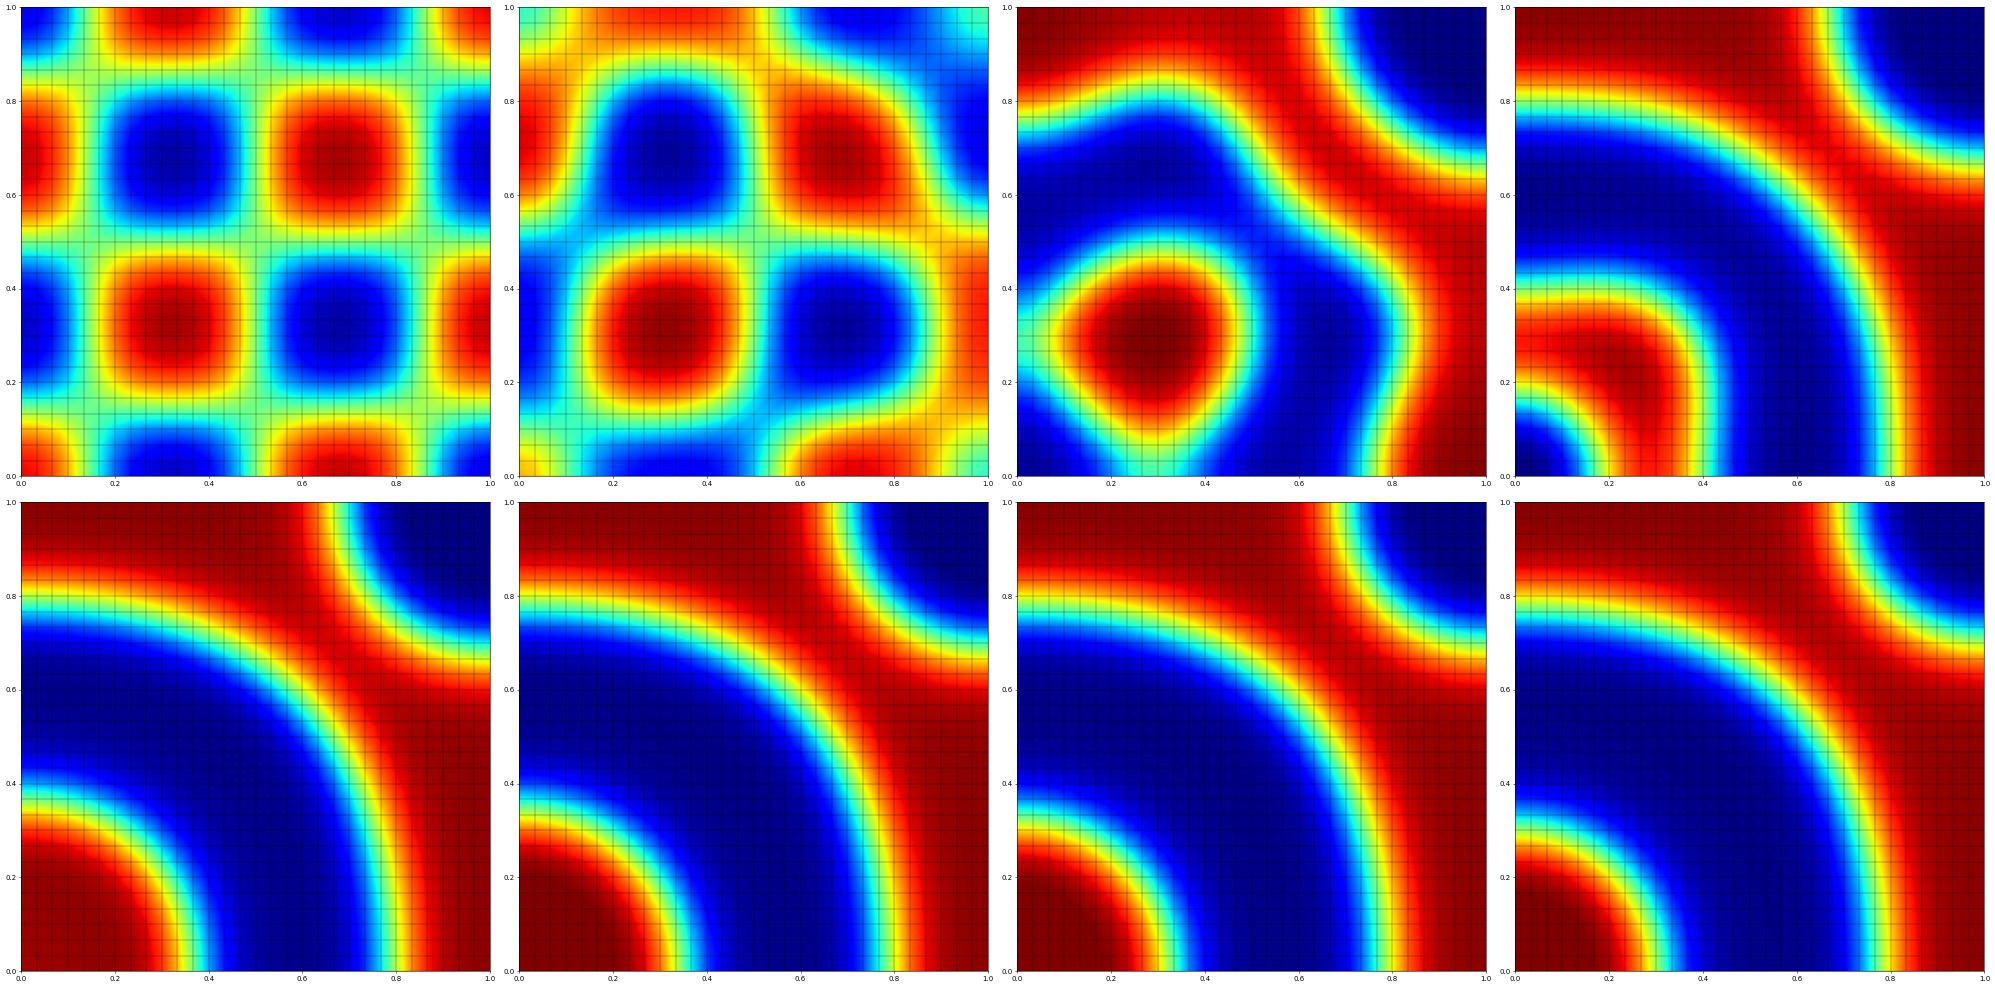

In [6]:
t.value = 0
eps.value = 0.05
tau.value = 1e-02

fig = pyplot.figure(figsize=(40,20))
count = 0
pos = 1
while t.value < 0.8:
    df_n.assign(df)
    info = scheme.solve(target=df)
    t.value += tau
    count += 1
    if count % 10 == 0:
        df.plot(figure=(fig,240+pos),colorbar=None,clim=[-1,1])
        energy = dune.fem.integrate(Eint(df),order=3)
        print("[",pos,"]",t.value,tau.value,energy,info,flush=True)
        pos += 1

For the final coarsening phase we increase the time step a bit:

[ 1 ] 1.2000000000000008 0.04 0.09159602767561528 {'converged': True, 'iterations': 3, 'linear_iterations': 3, 'timing': [0.747863254, 0.455415804, 0.29244745]}


[ 2 ] 1.6000000000000012 0.04 0.07005804064768596 {'converged': True, 'iterations': 3, 'linear_iterations': 3, 'timing': [0.796861264, 0.490838957, 0.306022307]}


[ 3 ] 2.0000000000000013 0.04 0.05881699202552945 {'converged': True, 'iterations': 2, 'linear_iterations': 2, 'timing': [0.48769373, 0.295129722, 0.192564008]}


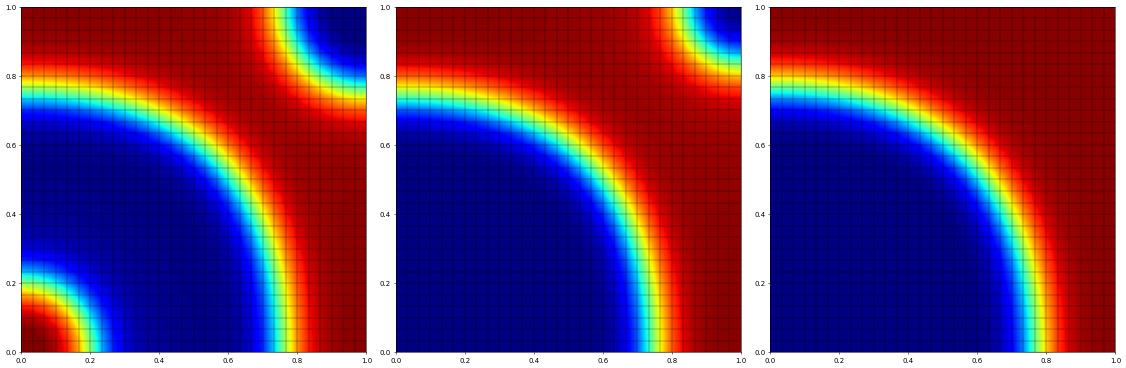

In [7]:
tau.value = 4e-02
fig = pyplot.figure(figsize=(30,10))
count = 0
pos = 1
while t.value < 2.0:
    df_n.assign(df)
    info = scheme.solve(target=df)
    t.value += tau
    count += 1
    if count % 10 == 0:
        df.plot(figure=(fig,140+pos),colorbar=None,clim=[-1,1])
        energy = dune.fem.integrate(Eint(df),order=3)
        print("[",pos,"]",t.value,tau.value,energy,info,flush=True)
        pos += 1